Taken from here: https://www.pymc-labs.com/blog-posts/bayesian-vector-autoregression

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import io
import os
from pathlib import Path
import warnings
import pymc as pm

az.style.use("arviz-darkgrid")
seed = sum(map(ord, "PyMC LABS - BVAR"))
rng = np.random.default_rng(seed=seed)

warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="openpyxl.worksheet._reader",
)

In [2]:
def simulate_ar(intercept, coef1, coef2, noise=1, *, warmup=10, steps=200):   
    # We sample some extra warmup steps, to let the AR process stabilize
    draws = np.zeros(warmup+steps)
    # Initialize first draws at intercept
    draws[:2] = intercept
    for step in range(2, warmup+steps):
        draws[step] = (
            intercept 
            + coef1 * draws[step-1]
            + coef2 * draws[step-2]
            + rng.normal(0, noise)
        )
    # Discard the warmup draws
    return draws[warmup:]

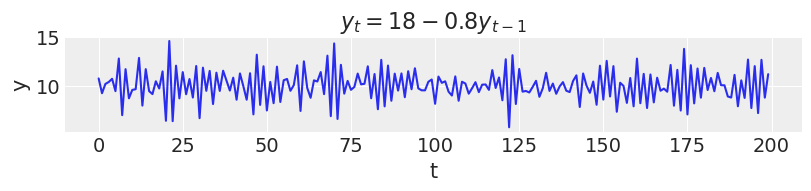

In [3]:
ar1 = simulate_ar(18, -0.8, 0)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar1)
ax.set_xlabel("t")
ax.set_ylabel("y")
ax.set_title("$y_t = 18 - 0.8y_{t-1}$");

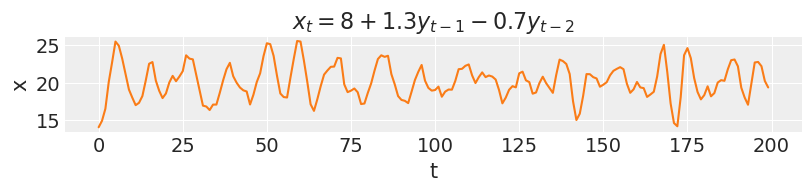

In [4]:
ar2 = simulate_ar(8, 1.3, -0.7)

_, ax = plt.subplots(figsize=(8, 1.8))
ax.plot(ar2, color="C1")
ax.set_xlabel("t")
ax.set_ylabel("x")
ax.set_title("$x_t = 8 + 1.3y_{t-1} - 0.7y_{t-2}$");

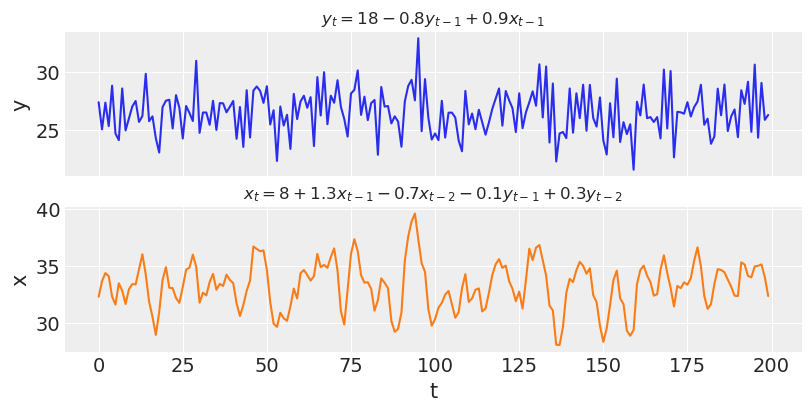

In [5]:
def simulate_var(intercepts, coefs_yy, coefs_xy, coefs_xx, coefs_yx, noises=(1, 1), *, warmup=100, steps=200):
    draws_y = np.zeros(warmup+steps)
    draws_x = np.zeros(warmup+steps)
    draws_y[:2] = intercepts[0]
    draws_x[:2] = intercepts[1]
    for step in range(2, warmup+steps):
        draws_y[step] = (
            intercepts[0]
            + coefs_yy[0] * draws_y[step-1]
            + coefs_yy[1] * draws_y[step-2]
            + coefs_xy[0] * draws_x[step-1]
            + coefs_xy[1] * draws_x[step-2]
            + rng.normal(0, noises[0])
        )
        draws_x[step] = (
            intercepts[1]
            + coefs_xx[0] * draws_x[step-1]
            + coefs_xx[1] * draws_x[step-2]
            + coefs_yx[0] * draws_y[step-1]
            + coefs_yx[1] * draws_y[step-2]
            + rng.normal(0, noises[1])
        )
    return draws_y[warmup:], draws_x[warmup:]
var_y, var_x = simulate_var(
    intercepts=(18, 8),
    coefs_yy=(-0.8, 0),
    coefs_xy=(0.9, 0),
    coefs_xx=(1.3, -0.7),
    coefs_yx=(-0.1, 0.3),
)

_, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(var_y)
ax[0].set_title("$y_t = 18 - 0.8y_{t-1} + 0.9x_{t-1}$", fontsize=12)
ax[0].set_ylabel("y")

ax[1].plot(var_x, color="C1")
ax[1].set_title("$x_t = 8 + 1.3x_{t-1} - 0.7x_{t-2} - 0.1y_{t-1} + 0.3y_{t-2}$", fontsize=12)
ax[1].set_ylabel("x")
ax[1].set_xlabel("t");

In [6]:
data_path = Path.cwd().parent / "data" / "us_macro_quarterly.xlsx"
print("Full file path:")
print(data_path)
print("")
print("File exists:")
print(data_path.exists())

Full file path:
/Users/awalters/escp_phd/pymc_bvar_example/data/us_macro_quarterly.xlsx

File exists:
True


In [7]:
df = pd.read_excel(data_path, index_col=0)

df.index = pd.to_datetime(
    df.index
    .str.replace(":01", "-01-01")
    .str.replace(":02", "-04-01")
    .str.replace(":03", "-07-01")
    .str.replace(":04", "-10-01")
)

df.rename(columns={"GDPC96": "GDP"}, inplace=True)

df = df[["GDP", "GS10", "TB3MS"]]
# This is an approximation of the annual growth rate
df["GDPGrowth"] = 400 * np.log(df["GDP"] / df["GDP"].shift())
# Term spread as the difference between 10-year and 3-month U.S. Treasury bonds
df["TSpread"] = df["GS10"] - df["TB3MS"] 
df = df["1960":]
df

,GDP,GS10,TB3MS,GDPGrowth,TSpread
1960-01-01,3120.195,4.486667,3.873333,8.813929,0.613333
1960-04-01,3108.361,4.260000,2.993333,-1.519969,1.266667
1960-07-01,3116.104,3.833333,2.360000,0.995170,1.473333
1960-10-01,3078.384,3.886667,2.306667,-4.871488,1.580000
1961-01-01,3099.314,3.786667,2.350000,2.710405,1.436667
...,...,...,...,...,...
2012-10-01,15539.628,1.706667,0.086667,0.145281,1.620000
2013-01-01,15583.948,1.950000,0.086667,1.139201,1.863333
2013-04-01,15679.677,1.996667,0.050000,2.449602,1.946667
2013-07-01,15839.347,2.710000,0.033333,4.052698,2.676667


In [8]:
data = df[["GDPGrowth", "TSpread"]][:-10]
test_data = df[["GDPGrowth", "TSpread"]][-10:]
data.shape, test_data.shape

((206, 2), (10, 2))

In [9]:
from matplotlib.colors import ColorConverter
colors = ("C0", "C1")

dark = {
    "C0": tuple(c * .35 for c in (ColorConverter.to_rgb("C0"))),
    "C1": tuple(c * .35 for c in (ColorConverter.to_rgb("C1"))),
}

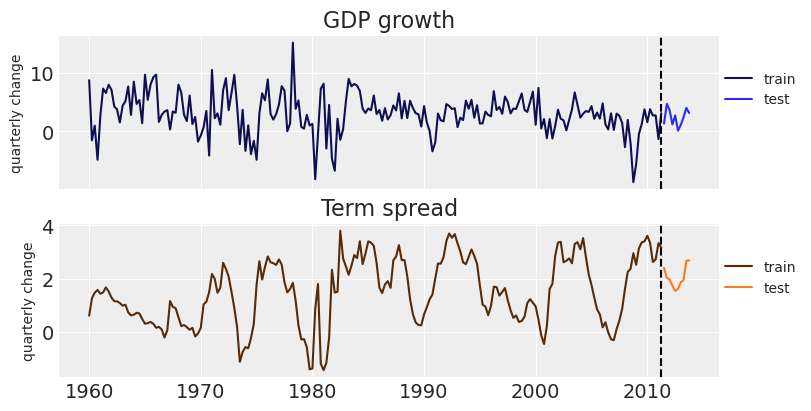

In [10]:
_, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True)
ax[0].plot(data["GDPGrowth"], color=dark["C0"], label="train")
ax[0].plot(test_data["GDPGrowth"], color="C0", label="test")
ax[0].set_ylabel("quarterly change", fontsize=10)
ax[0].set_title("GDP growth")

ax[1].plot(data["TSpread"], color=dark["C1"], label="train")
ax[1].plot(test_data["TSpread"], color="C1", label="test")
ax[1].set_ylabel("quarterly change", fontsize=10)
ax[1].set_title("Term spread");

for axi in ax:
    axi.axvline(df.index[-11], ls="--", color="k")
    axi.legend(loc=(1, 0.5), fontsize=10)

In [11]:
lags = 4

coords={
    "lags": reversed(range(-lags, 0)),
    "vars": ("GDPGrowth", "TSpread"),
    "cross_vars": ("GDPGrowth", "TSpread"),
    "time": range(len(data) - lags),
}

with pm.Model(coords=coords) as BVAR_model:
    # The first B bit:
    # Priors for the model intercept, lagged coefficients and noise terms
    intercept = pm.Normal("intercept", mu=0, sigma=1, dims=("vars",))
    lag_coefs = pm.Normal("lag_coefs", mu=0, sigma=1, dims=("lags", "vars", "cross_vars"))
    noise = pm.HalfNormal("noise", dims=("vars",))
    
    # The VAR bit:
    # Compute autoregressive expectation for each variable
    # We convolve the lagged coefficients of each variable with the whole dataset
    ar_GDPGrowth = pm.math.sum([
        pm.math.sum(lag_coefs[i, 0] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)        
    ar_TSpread = pm.math.sum([
        pm.math.sum(lag_coefs[i, 1] * data.values[lags-(i+1): -(i+1)], axis=-1)
        for i in range(lags)
    ], axis=0)   
    
    # Stack autoregressive terms and add intercepts
    mean = intercept + pm.math.stack([ar_GDPGrowth, ar_TSpread], axis=-1)
    
    # The second B bit:
    # For modelling simplicity, we ignore the first observations, where we could
    # not observe the effects of all the lagged coefficients
    obs = pm.Normal("obs", mu=mean, sigma=noise, observed=data[lags:], dims=("time", "vars"))

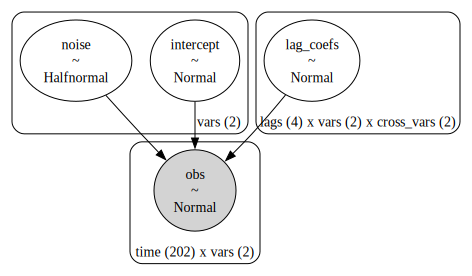

In [12]:
pm.model_to_graphviz(BVAR_model)

In [13]:
with BVAR_model:
    trace = pm.sample(chains=4, random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


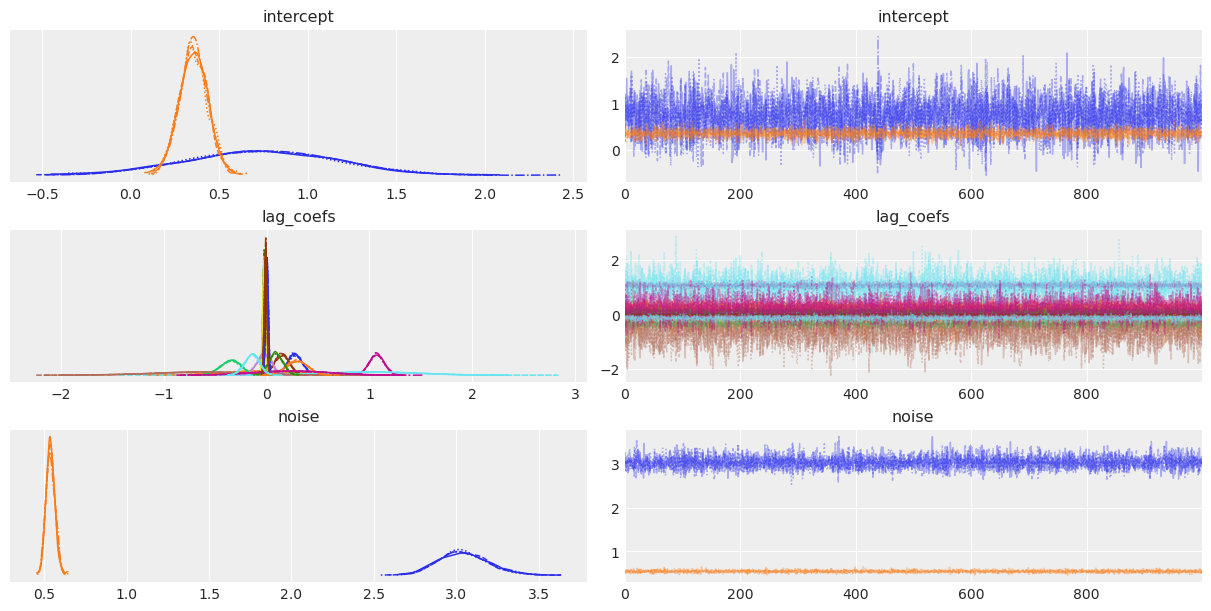

In [14]:
az.plot_trace(trace);

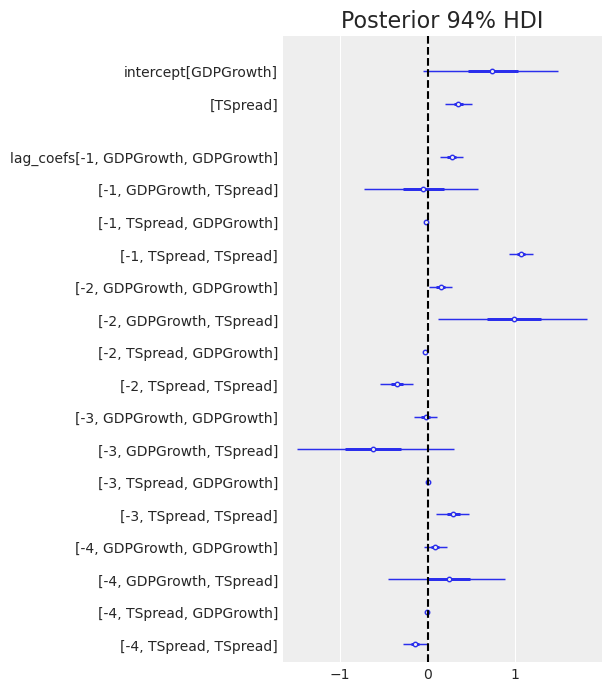

In [15]:
az.plot_forest(trace, var_names=["intercept", "lag_coefs"], combined=True, textsize=10)
plt.axvline(0, color="k", ls="--")
plt.title("Posterior 94% HDI");

In [16]:
# Function that takes a single draw of parameters and forecasts n steps
def _forecast(intercept, lag_coefs, noise, forecast=10):
    len_data = len(data)
    new_draws = np.zeros((data.shape[0]+forecast, data.shape[1]))
    # Fill the new array with the observed data
    new_draws[:len_data] = data[:]
    for i in range(forecast):
        ar_GDPGrowth = np.sum(lag_coefs[:, 0] * new_draws[len_data+i-lags: len_data+i])
        ar_TSpread = np.sum(lag_coefs[:, 1] * new_draws[len_data+i-lags: len_data+i])
        mean = intercept + np.stack([ar_GDPGrowth, ar_TSpread])
        new_draws[len_data+i] = rng.normal(mean, noise)
    # Replace all observed data with nan, so they don't show when we plot it
    new_draws[:-forecast-1] = np.nan
    return new_draws

# Vectorized forecast function to handle multiple parameter draws
forecast = np.vectorize(
    _forecast,
    signature=("(v),(l,v,v),(v)->(o,v)"),
    excluded=("forecast",),
)

/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_7750/3635143746.py:35: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


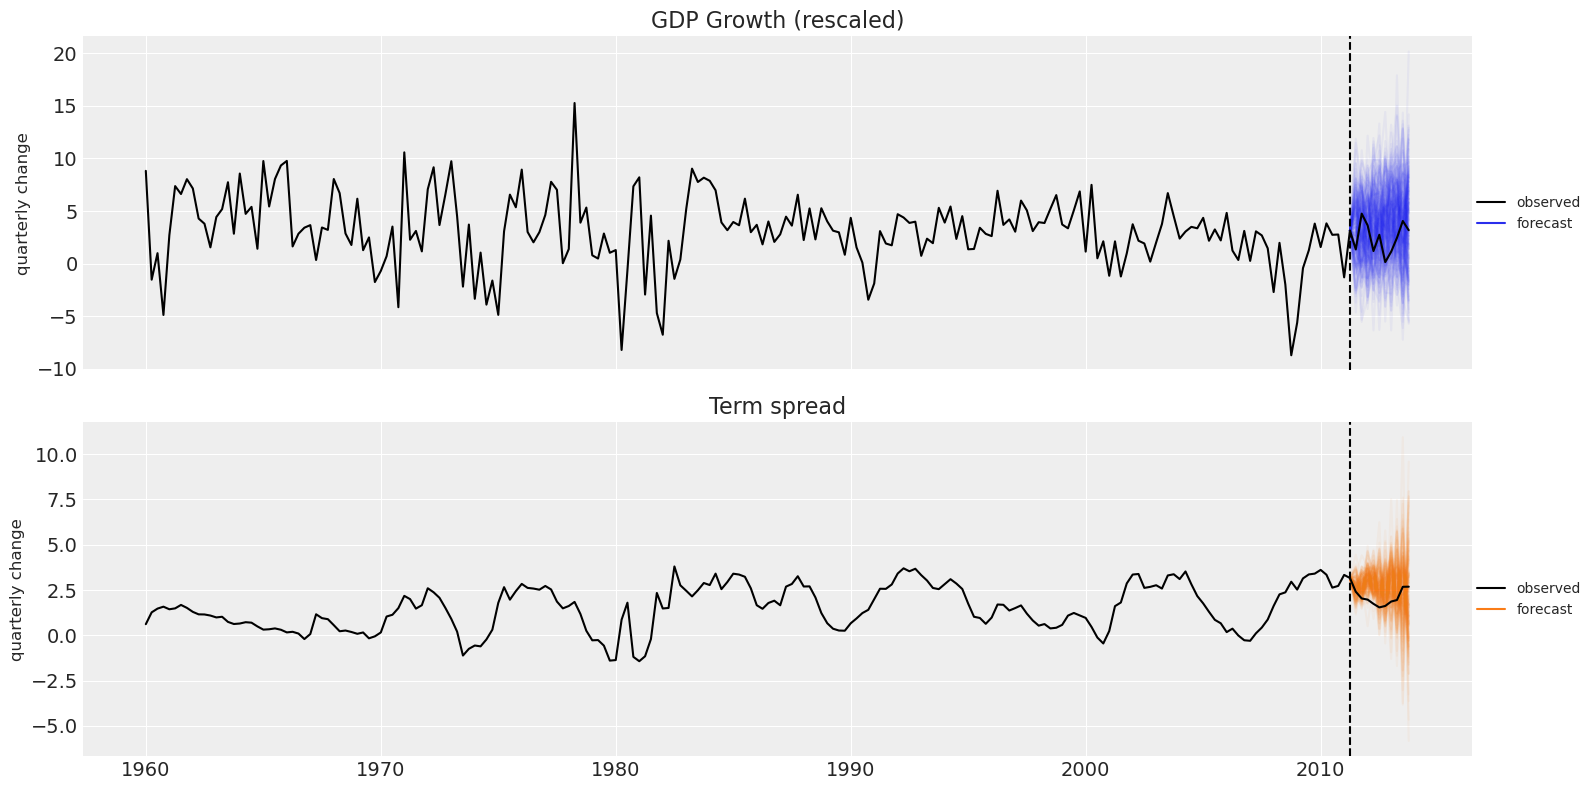

In [22]:
# Take a random subset of 100 draws from the posterior
draws = rng.integers(4000, size=200)

post = trace.posterior.stack(sample=("chain", "draw"))
intercept_draws = post["intercept"].values.T[draws]

lag_coefs_draws = post["lag_coefs"].values.T[draws].T
lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 0)

noise_draws = post["noise"].values.T[draws]

intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape
((100, 2), (100, 2, 2, 2), (100, 2))
# Forecast 10 quarters into the future
ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=10)
ppc_draws = np.swapaxes(ppc_draws, 0, 1)
_, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))

ax[0].set_title("GDP Growth (rescaled)")
ax[0].plot(df.index, ppc_draws[..., 0], color="C0", alpha=0.05)
ax[0].plot(df["GDPGrowth"], color="k", label="observed")
ax[0].plot([], color="C0", label="forecast")

ax[1].set_title("Term spread")
ax[1].plot(df.index, ppc_draws[..., 1], color="C1", alpha=0.05)
ax[1].plot(df["TSpread"], color="k", label="observed")
ax[1].plot([], color="C1", label="forecast")


for axi in ax:
    axi.axvline(data.index[-1], ls="--", color="k")
    axi.legend(fontsize=10, loc=(1, .4))
    axi.set_ylabel("quarterly change", fontsize=12)

plt.tight_layout()

/Users/awalters/miniforge3/envs/escp_phd/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1617: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_7750/2748317778.py:15: RuntimeWarning: All-NaN slice encountered
  gdp_median = np.nanmedian(ppc_draws[..., 0], axis=1)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_7750/2748317778.py:20: RuntimeWarning: All-NaN slice encountered
  ts_median = np.nanmedian(ppc_draws[..., 1], axis=1)
/var/folders/w8/rmt0d09s7yd6wt42l__22p3h0000gn/T/ipykernel_7750/2748317778.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


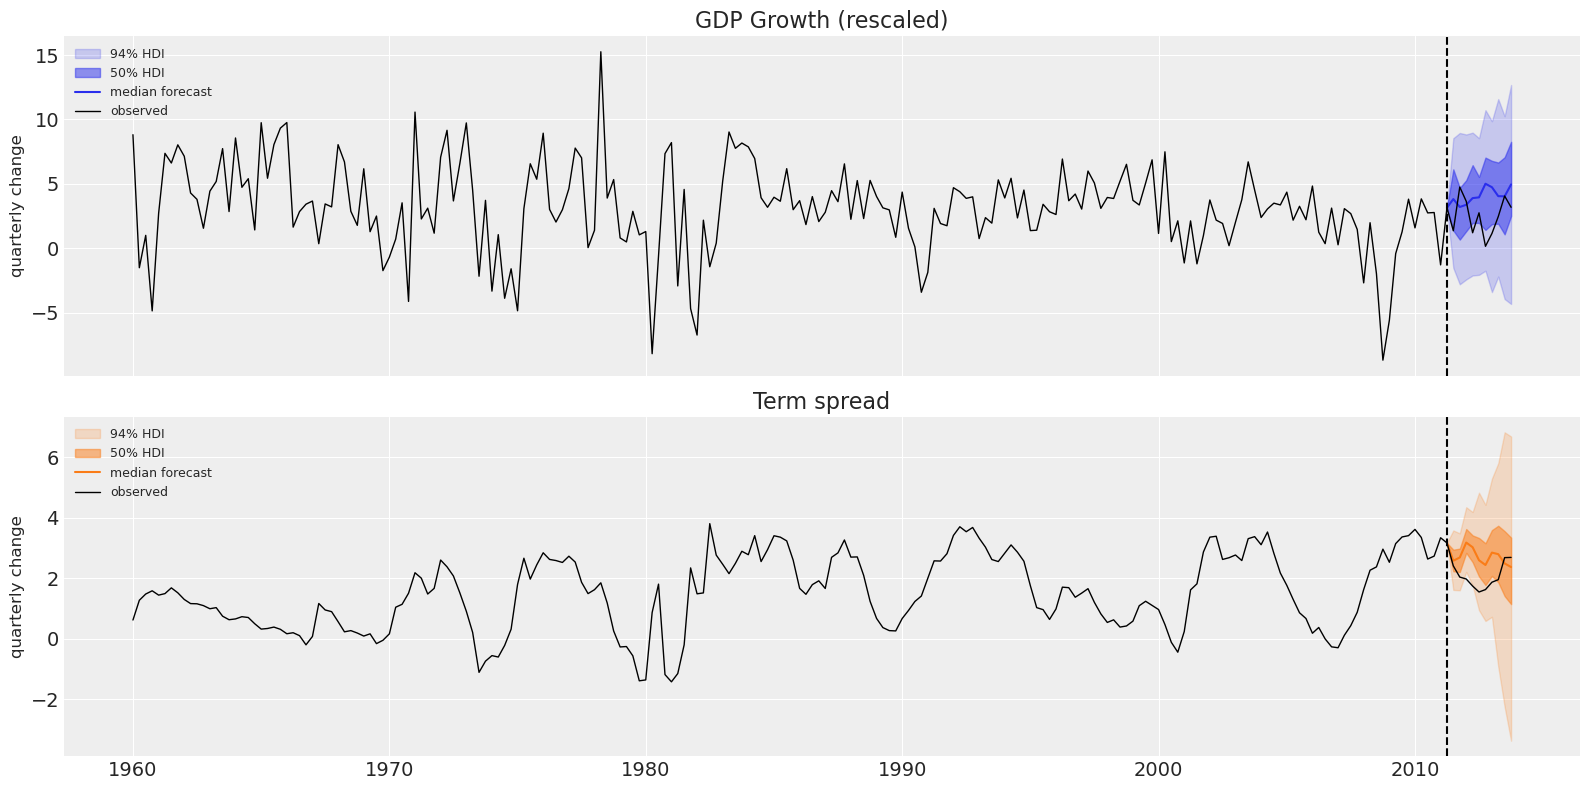

In [18]:
def hdi_from_draws(draws_2d, prob=0.94):
    """
    draws_2d: array shape (time, draws)
    returns: lower, upper arrays of shape (time,)
    """
    lower_q = 100 * (1 - prob) / 2
    upper_q = 100 * (1 + prob) / 2
    lower = np.nanpercentile(draws_2d, lower_q, axis=1)
    upper = np.nanpercentile(draws_2d, upper_q, axis=1)
    return lower, upper

# --- HDIs for GDPGrowth ---
gdp_lower94, gdp_upper94 = hdi_from_draws(ppc_draws[..., 0], prob=0.94)
gdp_lower50, gdp_upper50 = hdi_from_draws(ppc_draws[..., 0], prob=0.50)
gdp_median = np.nanmedian(ppc_draws[..., 0], axis=1)

# --- HDIs for TSpread ---
ts_lower94, ts_upper94 = hdi_from_draws(ppc_draws[..., 1], prob=0.94)
ts_lower50, ts_upper50 = hdi_from_draws(ppc_draws[..., 1], prob=0.50)
ts_median = np.nanmedian(ppc_draws[..., 1], axis=1)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))

# ---------- GDP Growth ----------
ax[0].set_title("GDP Growth (rescaled)")

# 94% HDI (wider, lighter)
ax[0].fill_between(
    df.index,
    gdp_lower94,
    gdp_upper94,
    color="C0",
    alpha=0.2,
    label="94% HDI",
)

# 50% HDI (narrower, darker)
ax[0].fill_between(
    df.index,
    gdp_lower50,
    gdp_upper50,
    color="C0",
    alpha=0.5,
    label="50% HDI",
)

# Median forecast line
ax[0].plot(df.index, gdp_median, color="C0", lw=1.5, label="median forecast")

# Observed data
ax[0].plot(df.index, df["GDPGrowth"], color="k", lw=1.0, label="observed")

# ---------- Term spread ----------
ax[1].set_title("Term spread")

ax[1].fill_between(
    df.index,
    ts_lower94,
    ts_upper94,
    color="C1",
    alpha=0.2,
    label="94% HDI",
)
ax[1].fill_between(
    df.index,
    ts_lower50,
    ts_upper50,
    color="C1",
    alpha=0.5,
    label="50% HDI",
)
ax[1].plot(df.index, ts_median, color="C1", lw=1.5, label="median forecast")
ax[1].plot(df.index, df["TSpread"], color="k", lw=1.0, label="observed")

for axi in ax:
    axi.axvline(data.index[-1], ls="--", color="k")
    axi.set_ylabel("quarterly change", fontsize=12)
    axi.legend(fontsize=9, loc="upper left")

plt.tight_layout()